# Time Series Forecasting

Author: Charles Liu
This notebook includes the data preprocessing, model training, validation and testing.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
ticker = 'CBA'

## Prepare data

### Select a ticker and read the data to data frame

In [2]:
# Read dataframe
from pricedata import read_stock_data, read_dates
df_raw = read_stock_data(ticker)
df_raw.shape

(879, 5)

In [3]:
df_raw.head(n=4)

,open,high,low,close,volume
date,,,,,
2015-01-02,85.42,85.74,85.12,85.74,944323
2015-01-05,85.70,86.24,85.51,85.95,1344368
2015-01-06,85.10,85.80,84.87,85.30,2463926
2015-01-07,85.31,85.49,84.55,85.11,2115727


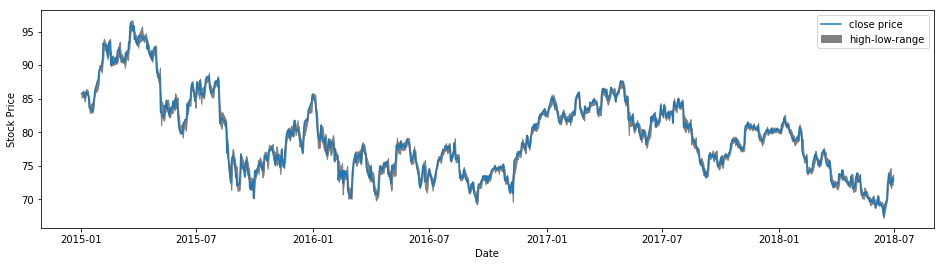

In [4]:
# Visualize the data. We see the the variance of the prices if much smaller than the variance across time
df = df_raw
fig = plt.figure(figsize=(16, 4))
plt.plot(df.index, df['close'], "-", label='close price')
plt.fill_between(df.index, y1=df['low'], y2=df['high'], color='gray', label='high-low-range')
plt.xlabel("Date")
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.close()

## Prepare the data
1. Handling missing data.

 1. Time interpolation.
 2. In general, with neural networks, it’s safe to input missing values as 0, with the condition
that 0 isn’t already a meaningful value. The network will learn from exposure to
the data that the value 0 means missing data and will start ignoring the value.

In [5]:
# Read full trading dates and create a dataframe with full trading dates. 
dates = read_dates()
# Get a dataframe with index of full dates
if len(dates) > len(df_raw):
    df_full = pd.DataFrame(index=dates, columns=df_raw.columns, dtype=float)
    df_full.loc[df_raw.index] = df_raw.astype(float)

# Discard the dates before the first valid data
df_full = df_full.loc[df_raw.index[0]:]
df_full.shape

(883, 5)

In [6]:
df_full.head()

,open,high,low,close,volume
2015-01-02,85.42,85.74,85.12,85.74,944323.0
2015-01-05,85.70,86.24,85.51,85.95,1344368.0
2015-01-06,85.10,85.80,84.87,85.30,2463926.0
2015-01-07,85.31,85.49,84.55,85.11,2115727.0
2015-01-08,85.54,85.65,85.13,85.39,1986996.0


In [7]:
if df_full.isna().sum().sum() > 0:
    df_full = df_full.interpolate(method='linear')
df_full.head()

,open,high,low,close,volume
2015-01-02,85.42,85.74,85.12,85.74,944323.0
2015-01-05,85.70,86.24,85.51,85.95,1344368.0
2015-01-06,85.10,85.80,84.87,85.30,2463926.0
2015-01-07,85.31,85.49,84.55,85.11,2115727.0
2015-01-08,85.54,85.65,85.13,85.39,1986996.0


2. Scaling

In this model, All five columns will be used as the input features. Because they have different scales, particularly, the the scale of volume data is much larger that prices.
So We need to scale of the data.

In [15]:
from sklearn import preprocessing
X = preprocessing.scale(df_full.values)
df_scaled = pd.DataFrame(index=df_full.index, data=X, columns=df_full.columns)
df_scaled.head()

,open,high,low,close,volume
2015-01-02,1.050708,1.017467,1.096217,1.107254,-1.487173
2015-01-05,1.099138,1.103871,1.163482,1.143434,-1.213036
2015-01-06,0.995359,1.027836,1.053098,1.031450,-0.445840
2015-01-07,1.031682,0.974266,0.997906,0.998717,-0.684450
2015-01-08,1.071463,1.001915,1.097942,1.046956,-0.772665


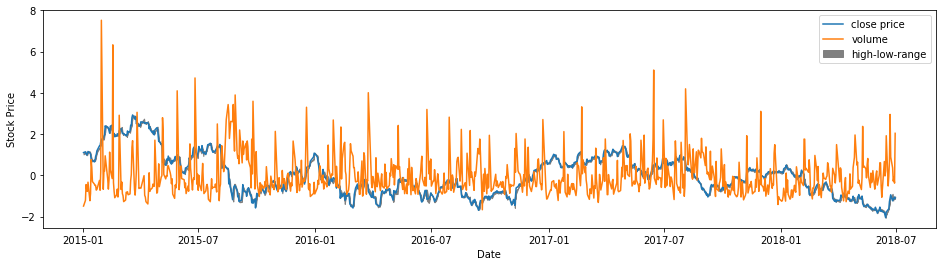

In [9]:
df = df_scaled
fig = plt.figure(figsize=(16, 4))
plt.plot(df.index, df['close'], "-", label='close price')
plt.fill_between(df.index, y1=df['low'], y2=df['high'], color='gray', label='high-low-range')
plt.plot(df.index, df['volume'], label='volume')
plt.xlabel("Date")
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.close()

### Prepare the training, validation and test data
Here are about my feature selection.
   1. The Open, high, low and high prices and the trading volume are used.
   2. Look back time: 5 days.

In [31]:
import copy
from helpers import sample_generator, vectorize_input, vectorize_target
lookback = 15
features = 5
delay = 1
step = 1

total_samples = len(df_full) - lookback - delay + 1
training_samples = int(total_samples * 0.6)
validation_samples = int(total_samples * 0.2)
test_samples = total_samples - training_samples - validation_samples

print("Total samples:", total_samples)
print("Training:", training_samples)
print("Validation:", validation_samples)
print("Test:", test_samples)


train_generator = sample_generator(df_scaled, lookback=lookback, delay=delay, start=0, end=training_samples, target_col=3)
valid_generator = sample_generator(df_scaled, lookback=lookback, delay=delay, start=training_samples,
                                       end=training_samples + validation_samples, target_col=3)
test_generator = sample_generator(df_scaled, lookback=lookback, delay=delay, start=training_samples + validation_samples,
                                 target_col=3)

train_data = list(train_generator)
valid_data = list(valid_generator)

X_train = vectorize_input(train_data)
y_train = vectorize_target(train_data)
X_valid = vectorize_input(valid_data)
y_valid = vectorize_target(valid_data)

X_train = X_train.reshape(X_train.shape[0], 1, lookback * features)
X_valid = X_valid.reshape(X_valid.shape[0], 1, lookback * features)
np.array(train_data).shape

Total samples: 868
Training: 520
Validation: 173
Test: 175


(520, 2)

### A forecasting model using recurrent neural networks

In [33]:
from keras.models import Sequential
from keras import layers

units = 64

model = Sequential()

model.add(layers.LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dropout(rate=0.2))

model.add(layers.LSTM(units=units, return_sequences=True))
model.add(layers.Dropout(rate=0.2))

model.add(layers.LSTM(units=units, return_sequences=True))
model.add(layers.Dropout(rate=0.2))

model.add(layers.LSTM(units=units))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(units=units, activation='relu'))
model.add(layers.Dense(units=units, activation='relu'))

model.add(layers.Dense(units=1))

model.compile(optimizer='RMSprop', loss='mean_absolute_error')
#model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=200, batch_size=lookback* features, validation_data=(X_valid, y_valid))

Train on 520 samples, validate on 348 samples
Epoch 1/200
520/520 [==============================] - 7s 13ms/step - loss: 0.8826 - val_loss: 0.5882
Epoch 2/200
520/520 [==============================] - 0s 364us/step - loss: 0.6130 - val_loss: 0.2992
Epoch 3/200
520/520 [==============================] - 0s 362us/step - loss: 0.3654 - val_loss: 0.2518
Epoch 4/200
520/520 [==============================] - 0s 362us/step - loss: 0.3022 - val_loss: 0.2329
Epoch 5/200
520/520 [==============================] - 0s 371us/step - loss: 0.2720 - val_loss: 0.2060
Epoch 6/200
520/520 [==============================] - 0s 370us/step - loss: 0.2429 - val_loss: 0.1900
Epoch 7/200
520/520 [==============================] - 0s 360us/step - loss: 0.2500 - val_loss: 0.1962
Epoch 8/200
520/520 [==============================] - 0s 366us/step - loss: 0.2421 - val_loss: 0.1919
Epoch 9/200
520/520 [==============================] - 0s 679us/step - loss: 0.2258 - val_loss: 0.2138
Epoch 10/200
520/520 [======

520/520 [==============================] - 0s 406us/step - loss: 0.1637 - val_loss: 0.1545
Epoch 80/200
520/520 [==============================] - 0s 418us/step - loss: 0.1699 - val_loss: 0.1693
Epoch 81/200
520/520 [==============================] - 0s 405us/step - loss: 0.1729 - val_loss: 0.1504
Epoch 82/200
520/520 [==============================] - 0s 406us/step - loss: 0.1731 - val_loss: 0.1594
Epoch 83/200
520/520 [==============================] - 0s 407us/step - loss: 0.1761 - val_loss: 0.1738
Epoch 84/200
520/520 [==============================] - 0s 730us/step - loss: 0.1693 - val_loss: 0.1556
Epoch 85/200
520/520 [==============================] - 0s 406us/step - loss: 0.1726 - val_loss: 0.1429
Epoch 86/200
520/520 [==============================] - 0s 406us/step - loss: 0.1796 - val_loss: 0.1429
Epoch 87/200
520/520 [==============================] - 0s 420us/step - loss: 0.1602 - val_loss: 0.1517
Epoch 88/200
520/520 [==============================] - 0s 415us/step - loss:

520/520 [==============================] - 0s 422us/step - loss: 0.1516 - val_loss: 0.1858
Epoch 158/200
520/520 [==============================] - 0s 426us/step - loss: 0.1487 - val_loss: 0.1840
Epoch 159/200
520/520 [==============================] - 0s 426us/step - loss: 0.1524 - val_loss: 0.1541
Epoch 160/200
520/520 [==============================] - 0s 746us/step - loss: 0.1567 - val_loss: 0.1806
Epoch 161/200
520/520 [==============================] - 0s 429us/step - loss: 0.1498 - val_loss: 0.1568
Epoch 162/200
520/520 [==============================] - 0s 427us/step - loss: 0.1510 - val_loss: 0.1829
Epoch 163/200
520/520 [==============================] - 0s 428us/step - loss: 0.1481 - val_loss: 0.1519
Epoch 164/200
520/520 [==============================] - 0s 430us/step - loss: 0.1570 - val_loss: 0.1639
Epoch 165/200
520/520 [==============================] - 0s 423us/step - loss: 0.1496 - val_loss: 0.1526
Epoch 166/200
520/520 [==============================] - 0s 424us/ste

In [27]:
# def build_model():
#     from keras.models import Sequential
#     from keras import layers
#     from keras.optimizers import RMSprop
#     model = Sequential()
#     model.add(layers.GRU(32, input_shape=(5, 25)))
#     model.add(layers.Dense(32, activation='relu'))
#     model.add(layers.Dense(1))
#     model.compile(optimizer=RMSprop(), loss='mae')
#     return model

# model = build_model()
# history = model.fit(X_train, y_train,
#     steps_per_epoch=32,
#     epochs=10)

In [ ]:
# from keras.models import Sequential
# from keras import layers
# from keras.optimizers import RMSprop
# model = Sequential()
# model.add(layers.GRU(32, input_shape=(5, 5)))
# model.add(layers.Dense(1))
# model.compile(optimizer=RMSprop(), loss='mae')

# train_generator = batch_generator(df_scaled, batch=batch, delay=delay, start=0, end=training_samples, target_col=3)
# history = model.fit_generator(train_generator,
#     steps_per_epoch=224,
#     epochs=5)

### Split the data to training, validation and test sets.

In [ ]:
X = np.ndarray(shape=[224, 25])
for i in range(len(X)):
    X[i] = X_train[i]

# Future close return classification

This forecasting model can be treated in two ways:
  1. regression, predict the close price of the next day, where the price is numeric
  2. Classification, predict the future close return is positive or negative

In [ ]:
28 * 28

In [ ]:
l = list(train_geneartor)

In [ ]:
X_train[:].shape

In [ ]:
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
224/7
